# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.48866 CV = 0.463102
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

Versão 1.0.1: LB = 0.48991 CV = 0.462946
- modelo: LightGBM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (com novas features)

## 1. Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler


## 2. Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino_reduce.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste_reduce.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [10]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 47 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 49 colunas


In [11]:
train.head()

,v31,v50,v110,v66,v129,v79,v47,v62,v56,v38,v74,v71,v24,v113,v3,v72,v30,v70,v57,v88,v69,v97,v125,v6,v102,v19,v90,v131,v22,v91,v120,v52,v107,v112,v10_bin,v14_bin,v17_bin,v34_bin,v46_bin,v51_bin,v54_bin,v58_bin,v64_bin,v65_bin,Naive Bayes0,Naive Bayes1,target
0,0,0.066833,0,0,0.0,0,0,1.0,0,0.0,0,0,0,0,0,1.0,0,0.667133,0.136931,0.229260,0.403141,0.603015,0,0.101695,0.134523,0.017569,0.094969,0.073298,0,0,0.170179,0,0,0,46,44,57,163,247,170,151,148,83,127,9.929674e-01,0.007033,0
1,0,0.121561,0,1,0.0,1,1,1.0,1,0.0,0,1,1,1,0,1.0,1,0.610796,0.203891,0.096209,0.472467,0.381128,1,0.121820,0.144514,0.011115,0.153338,0.086969,1,0,0.124224,1,0,0,58,34,168,197,131,152,100,130,235,184,8.728069e-01,0.127193,1
2,0,0.103734,0,0,0.0,2,2,1.0,2,0.0,0,1,2,0,0,1.0,-1,0.440164,0.160960,0.080480,0.435798,0.263333,2,0.113660,0.090351,0.012057,0.137807,0.070039,2,0,0.280203,0,0,1,58,60,57,97,66,248,31,79,83,34,9.859166e-01,0.014083,1
3,0,0.006089,0,2,0.0,3,1,2.0,-1,0.0,0,1,1,0,0,2.0,-1,0.610796,0.203891,0.096209,0.472467,0.381128,3,0.121820,0.144514,0.011115,0.153338,0.086969,3,1,0.124224,2,1,2,35,42,168,97,131,152,100,130,235,184,8.686117e-01,0.131388,0
4,1,0.129998,1,1,0.0,4,3,0.0,3,6.0,1,1,0,-1,0,6.0,-1,0.662712,0.179669,0.122931,0.363636,0.333333,4,0.160757,0.092970,0.008752,0.171870,0.090909,4,0,0.183766,3,0,3,52,135,124,142,30,151,31,32,213,228,2.806852e-53,1.000000,1


In [12]:
test.head()

,v31,v50,v110,v66,v129,v79,v47,v62,v56,v38,v74,v71,v24,v113,v3,v72,v30,v70,v57,v88,v69,v97,v125,v6,v102,v19,v90,v131,v22,v91,v120,v52,v107,v112,v10_bin,v14_bin,v17_bin,v34_bin,v46_bin,v51_bin,v54_bin,v58_bin,v64_bin,v65_bin,Naive Bayes0,Naive Bayes1,Class_proba_0,Class_proba_1,target_Stacked_predictions
0,0,0.005942,0,2,0.0,2,2,1.0,2,0.0,0,1,1,-1,0,1.0,-1,0.556759,0.130112,0.089219,0.428571,0.250000,19,0.104089,0.093697,0.011274,0.156837,7.142865e-02,10794,3,0.140448,7,3,7,46,98,168,97,31,238,25,17,214,133,8.839028e-01,0.116097,0.342483,0.657517,1
1,0,0.051354,1,1,0.0,6,3,1.0,4,4.0,0,1,3,-1,0,5.0,4,0.610828,0.203882,0.096218,0.472541,0.381237,53,0.121794,0.144778,0.011138,0.153290,8.681284e-02,113,2,0.124691,10,2,14,45,43,168,234,133,152,101,136,235,182,3.922881e-25,1.000000,0.140785,0.859215,1
2,0,0.042037,0,1,0.0,3,1,1.0,28,0.0,0,1,0,1,0,1.0,1,0.383383,0.272727,0.285714,0.333333,0.631579,66,0.077922,0.038148,0.008620,0.145697,1.809556e-08,18210,2,0.057724,10,2,17,52,156,126,180,0,248,13,0,213,133,7.963420e-01,0.203658,0.256234,0.743766,1
3,0,0.047319,0,0,0.0,3,1,1.0,0,0.0,0,1,1,0,0,1.0,5,0.706434,0.217826,0.021583,0.659751,0.430168,65,0.103917,0.144778,0.023828,0.237100,7.468887e-02,2444,3,0.223477,10,3,5,52,37,50,136,110,238,131,183,12,15,9.952730e-01,0.004727,0.365814,0.634186,1
4,0,0.074683,0,0,0.0,3,1,2.0,-1,0.0,0,1,1,13,0,2.0,1,0.656029,0.262980,0.111738,0.490566,0.382637,36,0.115124,0.074694,0.007441,0.157507,1.132076e-01,7527,3,0.081987,8,3,16,35,44,168,98,43,151,30,53,242,242,9.452363e-01,0.054764,0.347751,0.652249,1


## 3. Feature Engineering

In [13]:
test = test[test.columns[:-3]]

In [14]:
df = train.append(test)

In [15]:
df.head()

,Naive Bayes0,Naive Bayes1,target,v102,v107,v10_bin,v110,v112,v113,v120,v125,v129,v131,v14_bin,v17_bin,v19,v22,v24,v3,v30,v31,v34_bin,v38,v46_bin,v47,v50,v51_bin,v52,v54_bin,v56,v57,v58_bin,v6,v62,v64_bin,v65_bin,v66,v69,v70,v71,v72,v74,v79,v88,v90,v91,v97
0,9.929674e-01,0.007033,0.0,0.134523,0,46,0,0,0,0.170179,0,0.0,0.073298,44,57,0.017569,0,0,0,0,0,163,0.0,247,0,0.066833,170,0,151,0,0.136931,148,0.101695,1.0,83,127,0,0.403141,0.667133,0,1.0,0,0,0.229260,0.094969,0,0.603015
1,8.728069e-01,0.127193,1.0,0.144514,0,58,0,0,1,0.124224,1,0.0,0.086969,34,168,0.011115,1,1,0,1,0,197,0.0,131,1,0.121561,152,1,100,1,0.203891,130,0.121820,1.0,235,184,1,0.472467,0.610796,1,1.0,0,1,0.096209,0.153338,0,0.381128
2,9.859166e-01,0.014083,1.0,0.090351,0,58,0,1,0,0.280203,2,0.0,0.070039,60,57,0.012057,2,2,0,-1,0,97,0.0,66,2,0.103734,248,0,31,2,0.160960,79,0.113660,1.0,83,34,0,0.435798,0.440164,1,1.0,0,2,0.080480,0.137807,0,0.263333
3,8.686117e-01,0.131388,0.0,0.144514,1,35,0,2,0,0.124224,3,0.0,0.086969,42,168,0.011115,3,1,0,-1,0,97,0.0,131,1,0.006089,152,2,100,-1,0.203891,130,0.121820,2.0,235,184,2,0.472467,0.610796,1,2.0,0,3,0.096209,0.153338,1,0.381128
4,2.806852e-53,1.000000,1.0,0.092970,0,52,1,3,-1,0.183766,4,0.0,0.090909,135,124,0.008752,4,0,0,-1,1,142,6.0,30,3,0.129998,151,3,31,3,0.179669,32,0.160757,0.0,213,228,1,0.363636,0.662712,1,6.0,1,4,0.122931,0.171870,0,0.333333


## 4. Criar e avaliar alguns algoritmos de Machine Learning

## 4.1. Algoritmo LigthGBM


In [22]:
# Configurações Gerais

GENERATE_SUBMISSION_FILES = True
SUBMISSION_SUFIX = "_lgbm_v.1.0.1"
STRATIFIED_KFOLD = False
RANDOM_SEED = 42 #737851
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [23]:
# ------------------------- LIGHTGBM MODEL -------------------------

def run_model(data, categorical_feature = None):
    df = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    del_features = ['target']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['binary_logloss']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['binary_logloss']

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(df['target'], oof_preds))
    test['target'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Save submission (test data) and feature importance
        submission = pd.read_csv('../dataset/sample_submission.csv')
        submission['PredictedProb'] = sub_preds.copy()
        submission.to_csv('../submission/submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
        plt.hist(submission.PredictedProb)
        plt.show()
    return mean_importance

Train/valid shape: (114321, 47), test shape: (114393, 47)
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.472187	valid_1's binary_logloss: 0.482554
[800]	training's binary_logloss: 0.456463	valid_1's binary_logloss: 0.472124
[1200]	training's binary_logloss: 0.44667	valid_1's binary_logloss: 0.468767
[1600]	training's binary_logloss: 0.438357	valid_1's binary_logloss: 0.466909
[2000]	training's binary_logloss: 0.430807	valid_1's binary_logloss: 0.46582
[2400]	training's binary_logloss: 0.423854	valid_1's binary_logloss: 0.465083
[2800]	training's binary_logloss: 0.417358	valid_1's binary_logloss: 0.464512
[3200]	training's binary_logloss: 0.411196	valid_1's binary_logloss: 0.464106
[3600]	training's binary_logloss: 0.405219	valid_1's binary_logloss: 0.46348
Early stopping, best iteration is:
[3887]	training's binary_logloss: 0.40116	valid_1's binary_logloss: 0.46319
Fold  1 Log Loss : 0.463190
Training until validation scores don't impro

[4000]	training's binary_logloss: 0.40076	valid_1's binary_logloss: 0.455462
Early stopping, best iteration is:
[4171]	training's binary_logloss: 0.39844	valid_1's binary_logloss: 0.455303
Fold  9 Log Loss : 0.455303
Training until validation scores don't improve for 100 rounds
[400]	training's binary_logloss: 0.47307	valid_1's binary_logloss: 0.47461
[800]	training's binary_logloss: 0.457152	valid_1's binary_logloss: 0.464988
[1200]	training's binary_logloss: 0.447301	valid_1's binary_logloss: 0.461744
[1600]	training's binary_logloss: 0.439065	valid_1's binary_logloss: 0.460304
[2000]	training's binary_logloss: 0.431518	valid_1's binary_logloss: 0.459087
[2400]	training's binary_logloss: 0.42451	valid_1's binary_logloss: 0.458354
[2800]	training's binary_logloss: 0.417941	valid_1's binary_logloss: 0.457886
[3200]	training's binary_logloss: 0.411705	valid_1's binary_logloss: 0.457414
Early stopping, best iteration is:
[3497]	training's binary_logloss: 0.407339	valid_1's binary_logloss

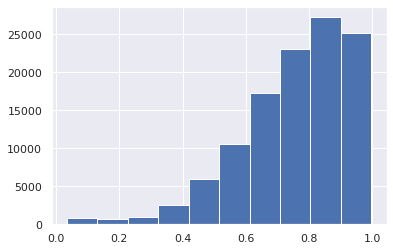

,feature,gain,split
24,v50,1.072386e+06,14070.4
0,Naive Bayes0,3.652628e+05,8963.9
1,Naive Bayes1,3.174988e+05,7248.3
15,v22,2.736729e+05,9276.6
28,v56,2.584525e+05,7786.8
35,v66,2.575983e+05,3585.8
20,v34_bin,2.134891e+05,6629.1
4,v10_bin,2.092989e+05,6845.8
9,v125,2.043105e+05,7025.7
36,v69,1.837651e+05,6753.8


In [24]:
run_model(df)